In [21]:
%reload_ext autoreload
%autoreload 2
import boto
s3_conn = boto.connect_s3()

from skills_ml.storage import FSStore, S3Store, ModelStorage
from skills_ml.job_postings.common_schema import JobPostingCollectionFromS3, JobPostingCollectionSample
from skills_ml.job_postings.filtering import JobPostingFilterer
from skills_ml.job_postings.raw.virginia import VirginiaTransformer
from skills_ml.job_postings.sample import JobSampler
from skills_ml.ontologies.onet import majorgroupname
from skills_utils.s3 import list_files

import multiprocessing
import os
import json
import statistics
import operator
from urllib.request import urlopen
from collections import Counter, defaultdict
from functools import reduce, partial
import logging
logging.basicConfig(level=logging.INFO)


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style="darkgrid", font_scale=2)
%matplotlib inline

In [82]:
# some plotting functions
def plot_major_group_distribution(job_postings):
    c = Counter()
    for job in job_postings:
        c.update([job['onet_soc_code'][:2]])
    s = pd.Series(c).sort_index()
    s.index = s.index.map(majorgroupname)
    ax = s.plot.bar(figsize=(20,10),rot=90)
    ax.set_xlabel('soc_major_group')
    ax.set_ylabel('number of job posting')
    ax.set_title(f"total number: {s.sum()}")
    return s



def algorithm_name(emb):
    if emb.model_type == 'word2vec' or emb.model_type == 'fasttext':
        if getattr(emb, 'sg', None) == 1:
            return 'Skip-Gram'
        else:
            return 'Continuous Bag of Words'
        
    elif emb.model_type == 'doc2vec':
        if getattr(emb, 'dm', None) == 1:
            return 'Distributed Memory'
        else:
            return 'Distributed Bag of Words'


def evaluate(embeddings, vectorization, metric):
    result = defaultdict(dict)
    for emb in embeddings:
        c = metric.eval(vectorization(emb))
        name = emb.model_name.split('.')[0]
        result[name]['mean'] = statistics.mean(list(c.values()))
        result[name]['variance'] = statistics.variance(list(c.values()))
        result[name]['std'] = statistics.stdev(list(c.values()))
        result[name]['max'] = max(c.items(), key=operator.itemgetter(1))[1]
        result[name]['max_cluster'] = max(c.items(), key=operator.itemgetter(1))[0]
        result[name]['min'] = min(c.items(), key=operator.itemgetter(1))[1]
        result[name]['min_cluster'] = min(c.items(), key=operator.itemgetter(1))[0]
        result[name]['type'] = emb.model_type
        result[name]['algorithm'] = algorithm_name(emb)
        result[name]['window'] = emb.window
    
    return pd.DataFrame(result)


def itershuffle(iterable, bufsize=1000):
    """Shuffle an iterator. This works by holding `bufsize` items back
    and yielding them sometime later. This is NOT 100% random, proved or anything."""
    iterable = iter(iterable)
    buf = []
    try:
        while True:
            for i in range(random.randint(1, bufsize-len(buf))):
                buf.append(next(iterable))
            random.shuffle(buf)
            for i in range(random.randint(1, bufsize)):
                if buf:
                    yield buf.pop()
                else:
                    break
    except StopIteration:
        random.shuffle(buf)
        while buf:
            yield buf.pop()
        raise StopIteration

# Spirit of Skills-ML

- **Dataflow Programming**: `Skills-ML`'s design philosophy builds on dataflow programming or so called data streaming to process very large datasets (larger than RAM; potentially infinite). 
- **One-pass algorithm**: Data points are processed one at a time.
- **Lazy evaluation**: an evaluation strategy which delays the evaluation of an expression until its value is needed. In `Skills-ML`, most of the classes and functions here incorporates the concept of `Iterable` or `Generator`. We build the expression first and evaluate later. 

# Skill and Competency Contexts

A skill/competency context describes the occurrence of a competency in some unstructured piece of text, such as a job posting or course description. Finding these occurrences is useful for many tasks, such as analyzing the demand for competencies in job postings or the available opportunities to learn competencies in college courses.

Most important is the context (e.g. the sentence or paragraph in which the occurrence resides). It enables a human or an algorithm to determine if an occurrence is a true reference to a competency. For example, job postings routinely include links to social media pages such as Facebook, Twitter, or LinkedIn associated with the hiring company. If the context of these social media links were not taken into consideration, then it would appear that all job postings would require Facebook, Twitter, and LinkedIn as competencies. However, managing company content on social media is itself a competency for some occupations such as a Social Media Manager. The context can help disambiguate these from true references to competencies.


# Creating Dataset

Before we do anything with the context, we need dataset. `Skills-ML` makes use of schema.org’s JobPosting standard. As it has been in use for a long time, some open sources are already using this standard, which is easy to import. Other job posting data sources are converted into the schema.org Schema and all work on job postings is done using this standard schema. 

In `Skills-ML`, `job_postings` module has all the functionalities to create the data we need for later usage. 

## Common Schema

We have an useful function to help create the data generator from s3. 

- `JobPostingCollectionFromS3`: Stream job posting from s3.
- `JobPostingCollectionSample`: Stream a finite number of job postings stored within the library.

However, we are not restrcted to just JobPosting data. One can easily create whatever data generator such as `ProfileGenerator` or `CourseGenerator`. 

For example, we want to use the Vrigina Dataset which is an open data set of job postings. We just have to create a job posting generator with some transformation. 

In [4]:
va_url = "http://opendata.cs.vt.edu/dataset/ab0abac3-2293-4c9d-8d80-22d450254389/resource/074f7e44-9275-4bba-874e-4795e8f6830c/download/openjobs-jobpostings.may-2016.json"

class VAJobposting(object):
    def __init__(self, uri):
        self.uri = uri
    
    def __iter__(self):
        request = urlopen(self.uri)
        for line in request.readlines():
            raw = json.loads(line)
            yield VirginiaTransformer(partner_id="va")._transform(raw)
            

jobpostings_va = VAJobposting(va_url)

In [5]:
print(len(list(jobpostings_va)))

40098


## Filtering

To create a good dataset, we might want to have some criteria for choosing the proper job posting based on the task we want to perform, like job postings that have the label information, job postings that belong to certain occupation, or job postings that have rich enough information in the description field.

- `JobPostingFilterer`: Filter common schema job postings through a number of filtering functions.

This function also follows lazy evaluation strategy.

In [6]:
def is_tech_jobs(job):
    if job['onet_soc_code'][:2] in ['15', '17', '19']:
        return True
    else:
        return False
    
tech_jobs = JobPostingFilterer(
    job_posting_generator=VAJobposting(va_url), 
    filter_funcs=[is_tech_jobs]
)

Computer and Mathematical             5065
Architecture and Engineering          1937
Life, Physical, and Social Science     192
dtype: int64

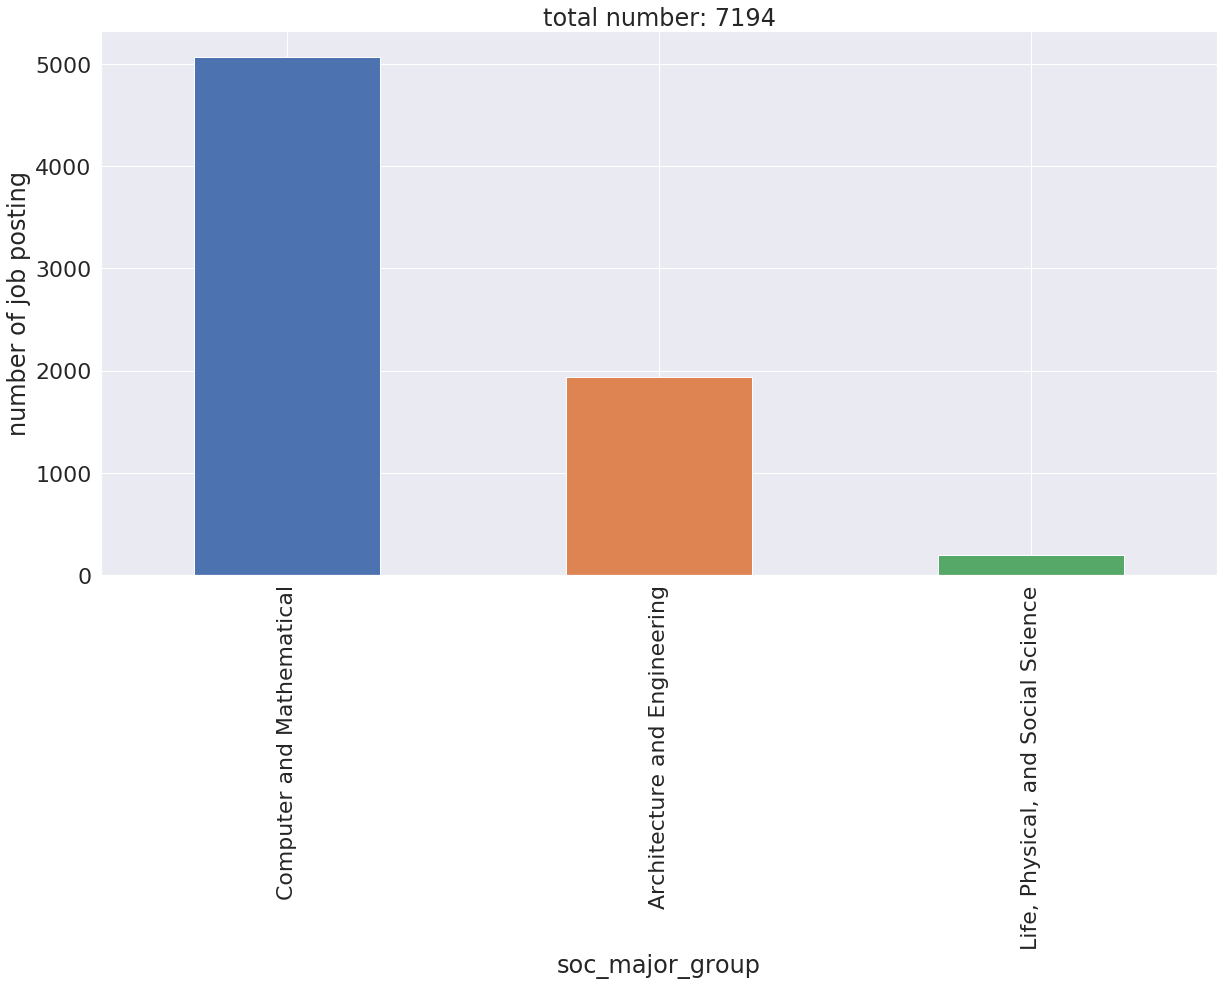

In [7]:
plot_major_group_distribution(tech_jobs)

What if we want to make sure that all the job postings have ONet SOC Code and it's not unknown(first 2 digit 99)? We can define filter functions like these which can be either generic function or lambda function.

In [8]:
def filter_onet_soc_code(job):
    if job['onet_soc_code'] and job['onet_soc_code'][:2] != '99':
        return True
    else:
        return False

has_soc = lambda x: x['onet_soc_code']
not_unknown_soc = lambda x: x['onet_soc_code'][:2] != '99'

In [9]:
jobpostings_filtered = JobPostingFilterer(
    job_posting_generator=VAJobposting(va_url), 
    filter_funcs=[has_soc, not_unknown_soc]
)

Management                                        6506
Business and Financial Operations                 3867
Computer and Mathematical                         5065
Architecture and Engineering                      1937
Life, Physical, and Social Science                 192
Community and Social Service                       282
Legal                                               94
Education, Training, and Library                   679
Arts, Design, Entertainment, Sports, and Media     598
Healthcare Practitioners and Technical            3447
Healthcare Support                                 494
Protective Service                                 484
Food Preparation and Serving Related               792
Building and Grounds Cleaning and Maintenance      189
Personal Care and Service                           97
Sales and Related                                 1415
Office and Administrative Support                 2580
Construction and Extraction                        196
Installati

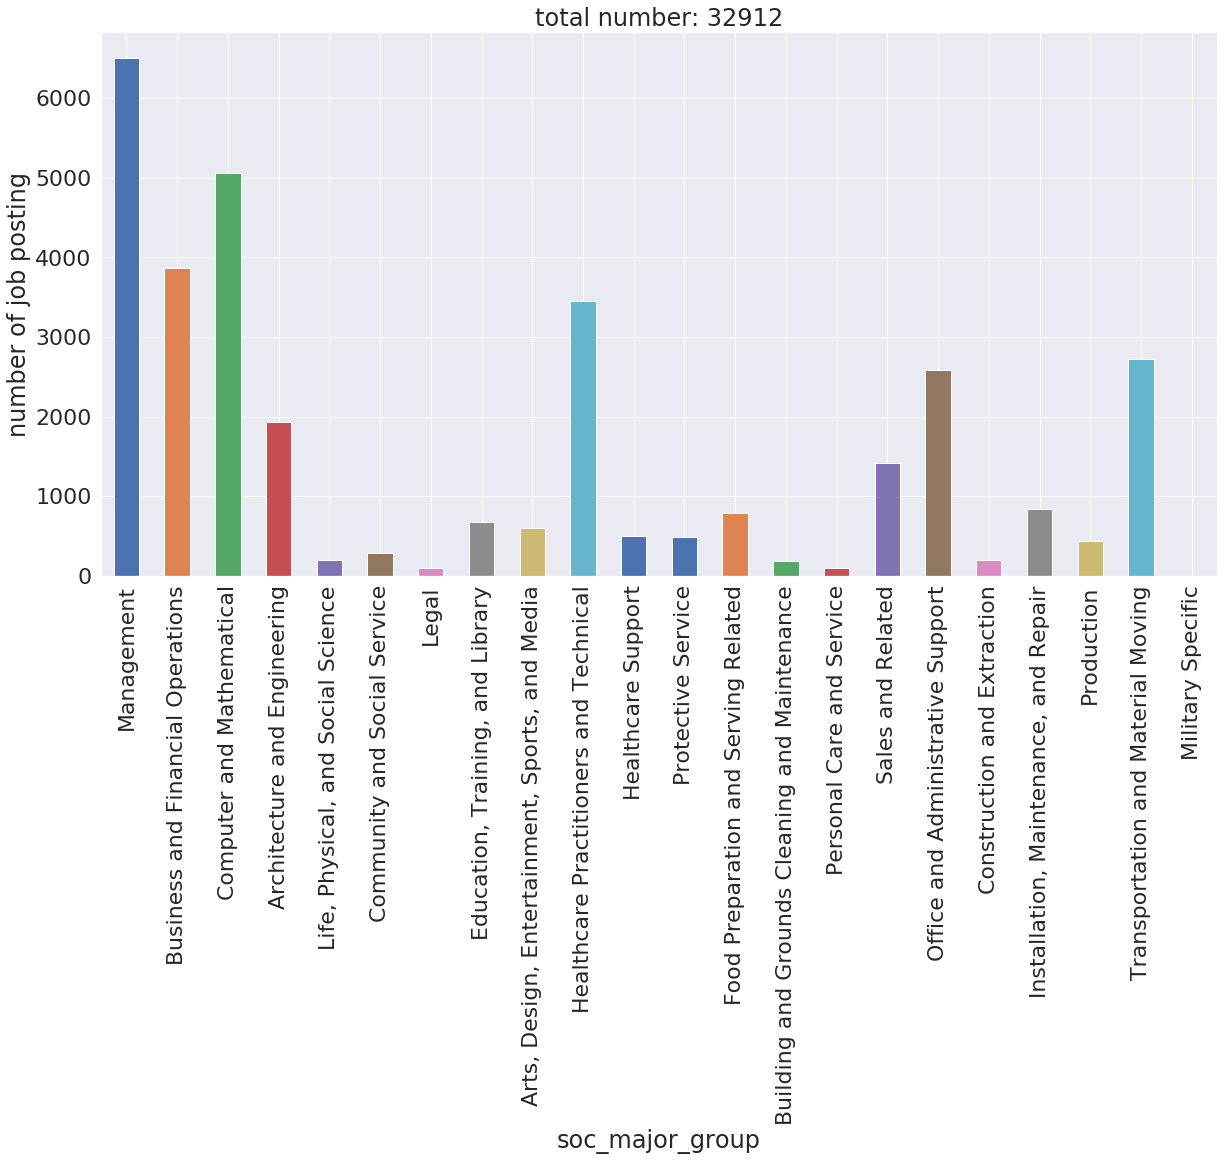

In [10]:
plot_major_group_distribution(jobpostings_filtered)

## Random Sampling

Even though we have a lot of data, most of time we don't need all of them to do the analysis. Or we can't even fit all the data into memory to do the analysis. What we need more importantly is a suitable sampled dataset.

- `JobSampler`: Sample job posting by (weighted) reservoir sampling. 

### Random Sampling from Streaming Data - Reservoir Sampling

- "Say you have a stream of items of large and unknown length that we can only iterate over once."
- It's memeory efficient and just one iteration
- There is a great overview of reservoir sampling in https://gregable.com/2007/10/reservoir-sampling.html. 

Let's say the original job postings dataset are too much for my Mac Yosemite to do any analysis and I want only 5000 job postings but still preserve the statistical characteristics of the original dataset. 

In [11]:
sampler = JobSampler(
    job_posting_generator=jobpostings_filtered, 
    k=5000,
)

Management                                        992
Business and Financial Operations                 592
Computer and Mathematical                         754
Architecture and Engineering                      287
Life, Physical, and Social Science                 30
Community and Social Service                       48
Legal                                              15
Education, Training, and Library                   95
Arts, Design, Entertainment, Sports, and Media     87
Healthcare Practitioners and Technical            505
Healthcare Support                                 76
Protective Service                                 73
Food Preparation and Serving Related              119
Building and Grounds Cleaning and Maintenance      29
Personal Care and Service                          16
Sales and Related                                 235
Office and Administrative Support                 402
Construction and Extraction                        23
Installation, Maintenance, a

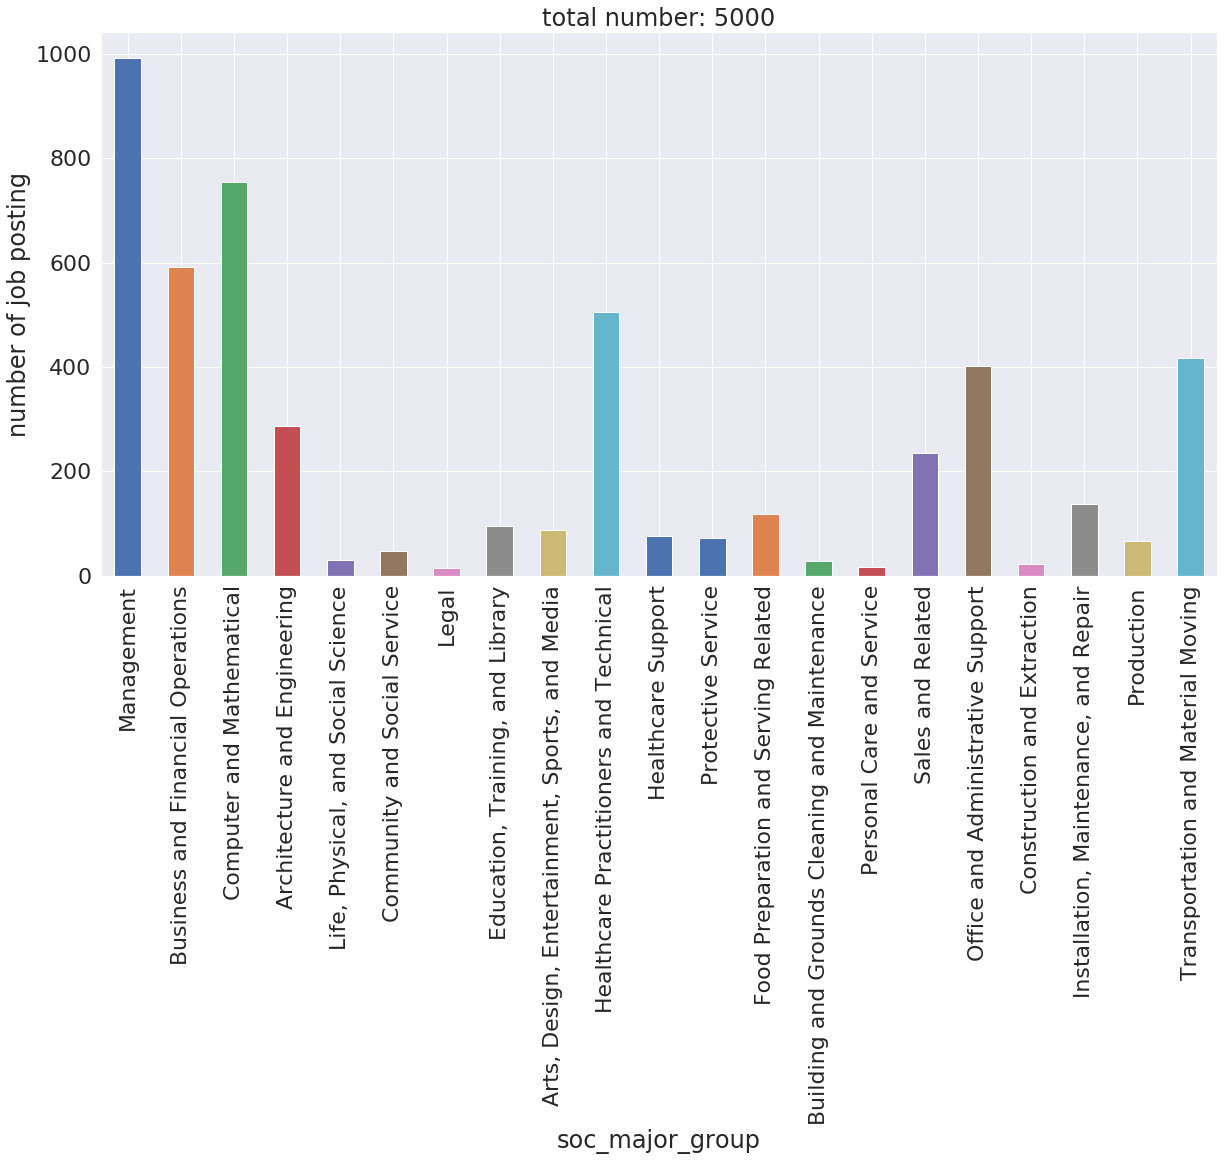

In [12]:
plot_major_group_distribution(sampler)

Something wrong happened! We are missing `Military Occupations`! Because military job postings are extremely rare in the original dataset, simple ramdom sampling might result in lack of classes.

## Weighted Reservoir Sampling

- How would you sample from a weighted distribution where each element has a given weight associated with it in the stream?

- For certain task, we need some curated sample. For example, if we want to build a occupation classifier, we want similar amounts of job posting for each occupation. 

Now we want to have a more uniform distributed sample across all major groups. 
Here we need to provide a weight dictionary in the `JobSampler`

In [13]:
c = Counter()
for job in jobpostings_filtered:
    c.update([job['onet_soc_code'][:2]])
weights = dict()
for key, value in c.items():
    weights[key] = max(c.values()) / value

In [14]:
weights

{'11': 1.0,
 '15': 1.2845014807502468,
 '17': 3.3588022715539494,
 '29': 1.8874383521903104,
 '41': 4.597879858657244,
 '43': 2.521705426356589,
 '13': 1.6824411688647531,
 '49': 7.819711538461538,
 '33': 13.442148760330578,
 '27': 10.879598662207357,
 '47': 33.19387755102041,
 '51': 14.71945701357466,
 '35': 8.214646464646465,
 '25': 9.581737849779087,
 '31': 13.17004048582996,
 '19': 33.885416666666664,
 '21': 23.070921985815602,
 '37': 34.423280423280424,
 '53': 2.3901542983100663,
 '39': 67.0721649484536,
 '23': 69.2127659574468,
 '55': 3253.0}

In [63]:
sampler = JobSampler(job_posting_generator=jobpostings_filtered, k=5000, major_group=True, weights=weights)

Management                                        334
Business and Financial Operations                 318
Computer and Mathematical                         319
Architecture and Engineering                      293
Life, Physical, and Social Science                154
Community and Social Service                      184
Legal                                              90
Education, Training, and Library                  235
Arts, Design, Entertainment, Sports, and Media    261
Healthcare Practitioners and Technical            324
Healthcare Support                                226
Protective Service                                231
Food Preparation and Serving Related              255
Building and Grounds Cleaning and Maintenance     152
Personal Care and Service                          95
Sales and Related                                 287
Office and Administrative Support                 298
Construction and Extraction                       164
Installation, Maintenance, a

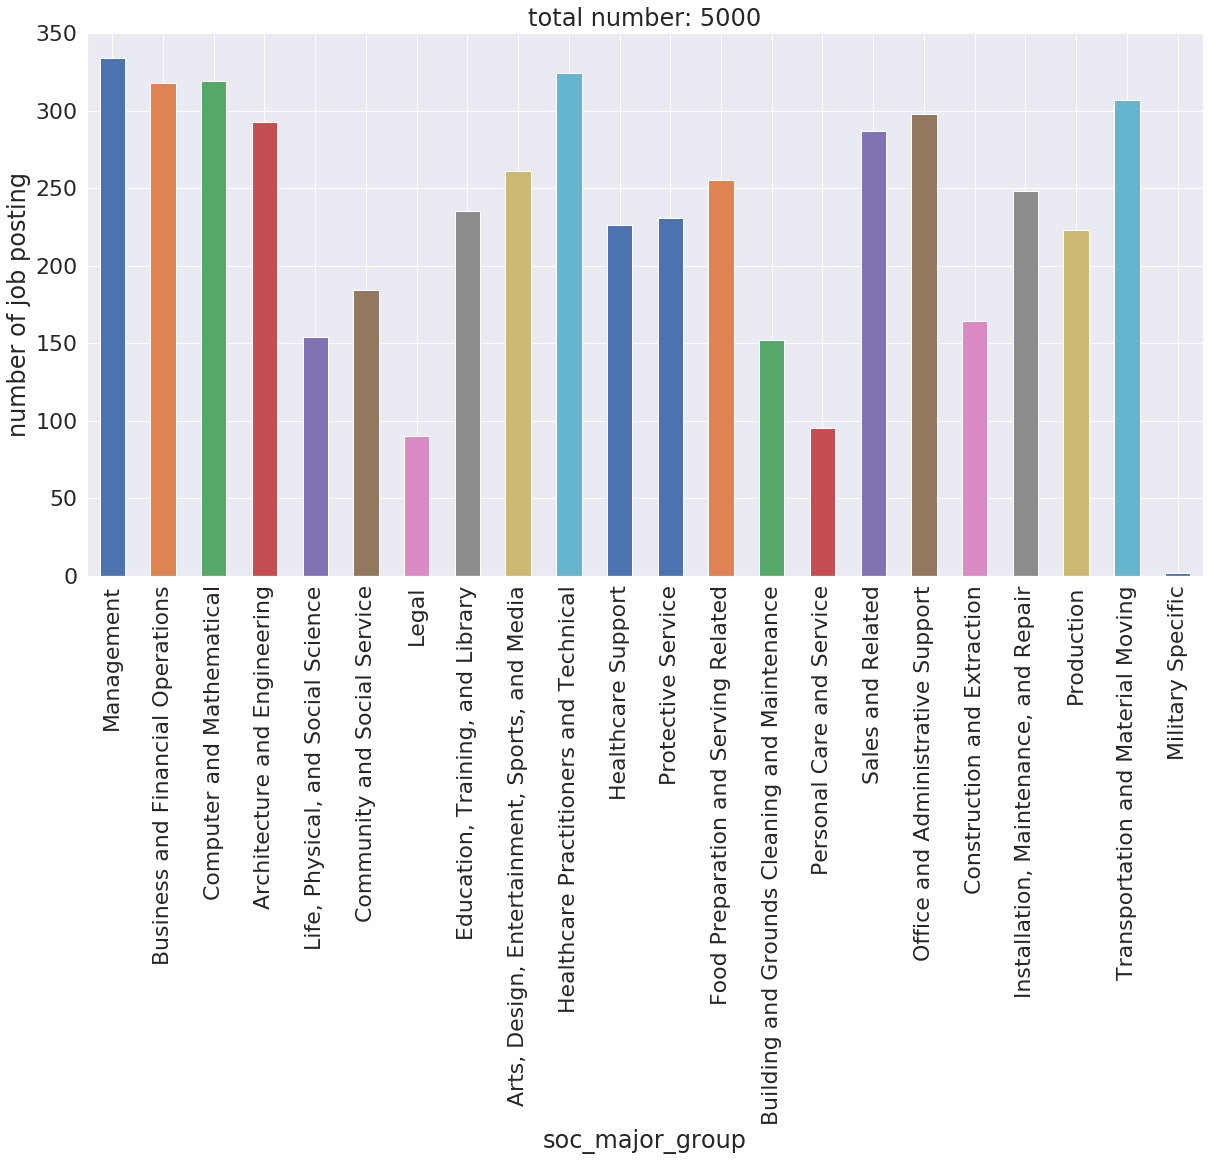

In [16]:
plot_major_group_distribution(sampler)

# Embedding

- Labor market data tends to be large in scale, but represented as raw text. Consequently, an important early step for most tasks is to transform texts into a mathematical form that can be used in the downstream tasks.

- In the context of skills and jobs, an embedding model trained on large amount of job posting data is able to map a skill or a job title into a high dimensional space as well as preserving the contextual and semantic relationship. Ideally, a good embedding model will cluster similar skills and jobs.

## Embedding Models

Many word embedding techniques have been developed since the most impactful embedding algorithm word2vec was published in 2013. Currently, Skills-ML includes word2vec, doc2vec and fastext and may include more in the future.

- `Word2VecModel` is able to look up a word vector and infer a sentence/paragraph vector by averaging each word in a sentence/paragraph. It supports online learning. For out-of-vocabulary word handling of sentence/paragraph inference, a random vector will be assigned with the same dimension.
- `Doc2VecModel` is able to look up a word vector and infer a sentence/paragraph vector by gradient descending on the fly, so it is non-deterministic. It does not support online learning. 
- `FastTextModel` is able to look up a word vector and infer a sentence/paragraph vector by averaging each word in a sentence/paragraph. It supports online learning. For out-of-vocabulary word handling of sentence/paragraph inference, it sums all vectors of the unseen word’s char-ngrams. If none of the char-ngrams of the unseen word is present, a random vector will be assigned with the same dimension.

In [17]:
from skills_ml.algorithms.embedding.models import Word2VecModel, FastTextModel

cbow = Word2VecModel(size=200, sg=0, window=7, iter=3)
skip_gram = Word2VecModel(size=200, sg=1, window=7, iter=3)
fasttext = FastTextModel(size=200, window=7, iter=3) 

## Corpora

Next, we need some text corpus to train embedding modelss. `Skills-ML` provides pre-defined classes to convert common schema job listings into a corpus in documnet level suitable for use by machine learning algorithms or specific tasks.

- `Word2VecGensimCorpusCreator`
- `Doc2VecGensimCorpusCreator`


In [18]:
from skills_ml.job_postings.corpora import Word2VecGensimCorpusCreator, Doc2VecGensimCorpusCreator

w2v_corpus_generator = Word2VecGensimCorpusCreator(sampler)

## Preprocessing

Or we can build our own corpus generator by using some preprocessing tools

Function Compostition
- `ProcessingPipeline` will compose processing functions together to become a callable object that takes in the input from the very first processing function and returns the output of the last processing function.
- `IterablePipeline` will compose processing functions together to be passed to different stages(training/          prediction)

In [19]:
from skills_ml.algorithms.preprocessing import IterablePipeline
from skills_ml.algorithms import nlp

document_schema_fields = ['description','experienceRequirements', 'qualifications', 'skills']

pipeline = IterablePipeline(
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.clean_html,
    nlp.clean_str,
    nlp.word_tokenize,
)

corpus_generator = pipeline(sampler)

## Train Embedding

The `EmbeddingTrainer` provides online batch learning for Word2VecModel and FastTextModel. 

In [20]:
from skills_ml.algorithms.embedding.train import EmbeddingTrainer


trainer = EmbeddingTrainer(cbow, skip_gram, fasttext, batch_size=100)
trainer.train(corpus_generator)

INFO:root:Training batch #0 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5213 word types from a corpus of 49808 raw words and 100 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=5 retains 1573 unique words (30% of original 5213, drops 3640)
INFO:gensim.models.word2vec:effective_min_count=5 leaves 43471 word corpus (87% of original 49808, drops 6337)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5213 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 50 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 33289 word corpus (76.6% of prior 43471)
INFO:gensim.models.base_any2vec:estimated required memory for 1573 words and 200 dimensions: 3303300 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.b

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5210 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 98 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 69163 word corpus (154.3% of prior 44833)
INFO:gensim.models.base_any2vec:estimated required memory for 3264 words and 200 dimensions: 6854400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 2013 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51151 raw words (35413 effective words) took 0.0s, 944700 effective words/s
INFO:gensim.models.base_any2vec:worker th

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 2323 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 49081 raw words (34378 effective words) took 0.0s, 932551 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 49081 raw words (34330 effective words) took 0.0s, 935117 effective words

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 48717 raw words (34082 effective words) took 0.0s, 903611 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 48717 raw words (33951 effective words) took 0.0s, 912939 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 48867 raw words (34419 effective words) took 0.0s, 895161 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 48867 raw words (34497 effective words) took 0.0s, 907256 effective words/s
INFO:gensim.models.base_any2vec:training on a 146601 raw words (103343 effective words) took 0.1s, 863583 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 55380 raw words (39407 effective words) took 0.0s, 985206 effective words/s
INFO:gensim.models.base_any2vec:training on a 166140 raw words (118105 effective words) took 0.1s, 946632 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5390 word types from a corpus of 55380 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1749 unique words (24% of original 7139) and increased the count of 1749 pre-existing words (24% of original 7139)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5390 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5354 word types from a corpus of 55033 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1723 unique words (24% of original 7077) and increased the count of 1723 pre-existing words (24% of original 7077)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5354 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 100 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 74192 word corpus (153.3% of prior 48393)
INFO:gensim.models.base_any2vec:estimated required memory for 3446 words and 200 dimensions: 7236600 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3048 vocabulary and 200 features, using sg=1

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1609 unique words (23% of original 6867) and increased the count of 1609 pre-existing words (23% of original 6867)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5258 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68618 word corpus (153.8% of prior 44608)
INFO:gensim.models.base_any2vec:estimated required memory for 3218 words and 200 dimensions: 6757800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3167 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread f

INFO:gensim.models.word2vec:downsampling leaves estimated 62298 word corpus (152.3% of prior 40905)
INFO:gensim.models.base_any2vec:estimated required memory for 3058 words and 200 dimensions: 6421800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 3254 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 47310 raw words (33924 effective words) took 0.2s, 209889 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.

INFO:gensim.models.base_any2vec:training model with 3 workers on 3326 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 50272 raw words (36564 effective words) took 0.2s, 206375 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 50272 raw words (36673 effective words) took 0.2s, 206230 effective words/s
INFO:gensim.models.base_any2vec:worker thread fi

INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51254 raw words (37651 effective words) took 0.2s, 214030 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 51254 raw words (37699 effective words) took 0.2s, 215840 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 51254 raw words (37772 effective words) took 0.2s, 215611 effective words/s
INFO:gensim.models.base_any2vec:training on a 153762 raw words (

INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 50094 raw words (36730 effective words) took 0.2s, 213769 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 50094 raw words (36702 effective words) took 0.2s, 210279 effective words/s
INFO:gensim.models.base_any2vec:training on a 150282 raw words (110064 effective words) took 0.5s, 210219 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5046 word types from a corpus of 50094 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.mo

INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 53125 raw words (38755 effective words) took 0.2s, 229864 effective words/s
INFO:gensim.models.base_any2vec:training on a 159375 raw words (116316 effective words) took 0.5s, 226781 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5238 word types from a corpus of 53125 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1666 unique words (24% of original 6904) and increased the count of 1666 pre-existing words (24% of original 6904)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5238 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 88 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 71883 word corpus (153.8% of prior 46753)
INFO:gensim.

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5127 word types from a corpus of 54870 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1706 unique words (24% of original 6833) and increased the count of 1706 pre-existing words (24% of original 6833)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5127 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 75241 word corpus (154.0% of prior 48849)
INFO:gensim.models.fasttext:estimated required memory for 3657 words, 29286 buckets and 200 dimensions: 31943764 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 604
INFO:gensim.models.base_any2vec:training m

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5338 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 88 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 66558 word corpus (153.0% of prior 43512)
INFO:gensim.models.fasttext:estimated required memory for 3738 words, 29790 buckets and 200 dimensions: 32535264 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 504
INFO:gensim.models.base_any2vec:training model with 3 workers on 3738 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 50146 raw words (36309 effective words) took 0.3s

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 375
INFO:gensim.models.base_any2vec:training model with 3 workers on 3788 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 43859 raw words (31993 effective words) took 0.3s, 113300 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 43859 raw words (

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51446 raw words (37697 effective words) took 0.3s, 130788 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 51446 raw words (37817 effective words) took 0.3s, 129666 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 52161 raw words (38182 effective words) took 0.4s, 96483 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 52161 raw words (38186 effective words) took 0.3s, 145679 effective words/s
INFO:gensim.models.base_any2vec:training on a 156483 raw words (114428 effective words) took 0.9s, 123701 effective words/s
INFO:root:Training batch #18 
INFO:gensim.models.word2vec:collecting all 

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 52532 raw words (38999 effective words) took 0.3s, 137621 effective words/s
INFO:gensim.models.base_any2vec:training on a 157596 raw words (116952 effective words) took 0.9s, 136073 effective words/s
INFO:root:Training batch #19 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5187 word types from a corpus of 50957 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1626 unique words (23% of original 6813) and increased the count of 1626 pre-e

INFO:gensim.models.base_any2vec:training on a 152871 raw words (112370 effective words) took 0.8s, 138601 effective words/s
INFO:root:Training batch #20 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5705 word types from a corpus of 54626 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1739 unique words (23% of original 7444) and increased the count of 1739 pre-existing words (23% of original 7444)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5705 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 88 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 72593 word corpus (153.0% of prior 47457)
INFO:gensim.models.base_any2vec:estimated required memory for 3478 words and 200 dimensions: 7303800 bytes
INFO:ge

INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5438 word types from a corpus of 55679 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1727 unique words (24% of original 7165) and increased the count of 1727 pre-existing words (24% of original 7165)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5438 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 90 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 75751 word corpus (154.9% of prior 48889)
INFO:gensim.models.base_any2vec:estimated required memory for 3454 words and 200 dimensions: 7253400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4089 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5382 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 96 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68405 word corpus (152.1% of prior 44964)
INFO:gensim.models.base_any2vec:estimated required memory for 3236 words and 200 dimensions: 6795600 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4159 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51740 raw words (37374 effective words) took 0.0s, 913149 effective words/s
INFO:gensim.models.base_any2vec:worker th

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4231 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 55154 raw words (40629 effective words) took 0.0s, 1004366 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 55154 raw words (40703 effective words) took 0.0s, 1009853 effective wor

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 54791 raw words (40710 effective words) took 0.0s, 1028139 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 54791 raw words (40758 effective words) took 0.0s, 1035611 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mo

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 45753 raw words (33833 effective words) took 0.0s, 912650 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 45753 raw words (33685 effective words) took 0.0s, 907068 effective words/s
INFO:gensim.models.base_any2vec:training on a 137259 raw words (101279 effective words) took 0.1s, 860063 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 47689 raw words (35326 effective words) took 0.0s, 923242 effective words/s
INFO:gensim.models.base_any2vec:training on a 143067 raw words (106037 effective words) took 0.1s, 877527 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5171 word types from a corpus of 47689 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1546 unique words (23% of original 6717) and increased the count of 1546 pre-existing words (23% of original 6717)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5171 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5478 word types from a corpus of 55454 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1731 unique words (24% of original 7209) and increased the count of 1731 pre-existing words (24% of original 7209)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5478 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 92 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 74704 word corpus (153.1% of prior 48790)
INFO:gensim.models.base_any2vec:estimated required memory for 3462 words and 200 dimensions: 7270200 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4389 vocabulary and 200 features, using sg=1 

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1709 unique words (23% of original 7357) and increased the count of 1709 pre-existing words (23% of original 7357)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5648 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 96 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 70299 word corpus (153.6% of prior 45762)
INFO:gensim.models.base_any2vec:estimated required memory for 3418 words and 200 dimensions: 7177800 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4437 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread f

INFO:gensim.models.word2vec:downsampling leaves estimated 70203 word corpus (153.1% of prior 45858)
INFO:gensim.models.base_any2vec:estimated required memory for 3324 words and 200 dimensions: 6980400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 4475 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 52115 raw words (38497 effective words) took 0.2s, 230034 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.

INFO:gensim.models.base_any2vec:training model with 3 workers on 4526 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 57786 raw words (42973 effective words) took 0.2s, 237509 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 57786 raw words (42990 effective words) took 0.2s, 238461 effective words/s
INFO:gensim.models.base_any2vec:worker thread fi

INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 51019 raw words (37673 effective words) took 0.2s, 218674 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 51019 raw words (37573 effective words) took 0.2s, 220032 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 51019 raw words (37691 effective words) took 0.2s, 218492 effective words/s
INFO:gensim.models.base_any2vec:training on a 153057 raw words (

INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 46574 raw words (34268 effective words) took 0.2s, 204599 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 46574 raw words (34286 effective words) took 0.2s, 203364 effective words/s
INFO:gensim.models.base_any2vec:training on a 139722 raw words (102899 effective words) took 0.5s, 201840 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5215 word types from a corpus of 46574 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.mo

INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 50773 raw words (37011 effective words) took 0.2s, 223250 effective words/s
INFO:gensim.models.base_any2vec:training on a 152319 raw words (111225 effective words) took 0.5s, 220045 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5726 word types from a corpus of 50773 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1644 unique words (22% of original 7370) and increased the count of 1644 pre-existing words (22% of original 7370)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5726 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 92 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 66528 word corpus (152.9% of prior 43516)
INFO:gensim.

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5712 word types from a corpus of 58212 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1823 unique words (24% of original 7535) and increased the count of 1823 pre-existing words (24% of original 7535)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5712 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 86 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 78943 word corpus (154.4% of prior 51122)
INFO:gensim.models.fasttext:estimated required memory for 4693 words, 35639 buckets and 200 dimensions: 39437076 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 420
INFO:gensim.models.base_any2vec:training m

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5331 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 96 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 64080 word corpus (152.7% of prior 41979)
INFO:gensim.models.fasttext:estimated required memory for 4736 words, 35894 buckets and 200 dimensions: 39740976 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 255
INFO:gensim.models.base_any2vec:training model with 3 workers on 4736 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 48649 raw words (35842 effective words) took 0.3s

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.fasttext:Number of new ngrams is 376
INFO:gensim.models.base_any2vec:training model with 3 workers on 4785 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 55873 raw words (41515 effective words) took 0.3s, 131103 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 55873 raw words (

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 59286 raw words (43847 effective words) took 0.3s, 139199 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 59286 raw words (43889 effective words) took 0.3s, 138989 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.mode

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 60251 raw words (44605 effective words) took 0.3s, 134982 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 60251 raw words (44544 effective words) took 0.3s, 133866 effective words/s
INFO:gensim.models.base_any2vec:training on a 180753 raw words (133668 effective words) took 1.0s, 133161 effective words/s
INFO:root:Training batch #39 
INFO:gensim.models.word2vec:collecting all

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 52939 raw words (39348 effective words) took 0.3s, 128185 effective words/s
INFO:gensim.models.base_any2vec:training on a 158817 raw words (118075 effective words) took 0.9s, 128132 effective words/s
INFO:root:Training batch #40 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5675 word types from a corpus of 53802 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1682 unique words (22% of original 7357) and increased the count of 1682 pre-e

INFO:gensim.models.base_any2vec:training on a 161406 raw words (118526 effective words) took 1.0s, 113421 effective words/s
INFO:root:Training batch #41 
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5280 word types from a corpus of 51096 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1653 unique words (23% of original 6933) and increased the count of 1653 pre-existing words (23% of original 6933)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5280 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 106 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 68650 word corpus (154.0% of prior 44567)
INFO:gensim.models.base_any2vec:estimated required memory for 3306 words and 200 dimensions: 6942600 bytes
INFO:g

INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5186 word types from a corpus of 48689 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1557 unique words (23% of original 6743) and increased the count of 1557 pre-existing words (23% of original 6743)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5186 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 98 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 65216 word corpus (153.7% of prior 42434)
INFO:gensim.models.base_any2vec:estimated required memory for 3114 words and 200 dimensions: 6539400 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5027 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2

INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5348 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 88 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 71039 word corpus (153.0% of prior 46441)
INFO:gensim.models.base_any2vec:estimated required memory for 3336 words and 200 dimensions: 7005600 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5043 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 53052 raw words (39534 effective words) took 0.0s, 949481 effective words/s
INFO:gensim.models.base_any2vec:worker th

INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5074 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 46588 raw words (34962 effective words) took 0.0s, 899192 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 46588 raw words (34907 effective words) took 0.0s, 919164 effective words

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 55208 raw words (40849 effective words) took 0.0s, 1021955 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 55208 raw words (40856 effective words) took 0.0s, 1037074 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.mo

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 49096 raw words (36401 effective words) took 0.0s, 909599 effective words/s
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 49096 raw words (36450 effective words) took 0.0s, 898070 effective words/s
INFO:gensim.models.base_any2vec:training on a 147288 raw words (109227 effective words) took 0.1s, 864386 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
IN

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 3 : training on 53638 raw words (39889 effective words) took 0.0s, 994729 effective words/s
INFO:gensim.models.base_any2vec:training on a 160914 raw words (119772 effective words) took 0.1s, 947820 effective words/s
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5426 word types from a corpus of 53638 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1740 unique words (24% of original 7166) and increased the count of 1740 pre-existing words (24% of original 7166)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5426 items
INFO:g

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 5636 word types from a corpus of 62222 raw words and 100 sentences
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1846 unique words (24% of original 7482) and increased the count of 1846 pre-existing words (24% of original 7482)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5636 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 85044 word corpus (153.3% of prior 55490)
INFO:gensim.models.base_any2vec:estimated required memory for 3692 words and 200 dimensions: 7753200 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5197 vocabulary and 200 features, using sg=1 

INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 1551 unique words (23% of original 6670) and increased the count of 1551 pre-existing words (23% of original 6670)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 5119 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 94 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 64841 word corpus (152.9% of prior 42402)
INFO:gensim.models.base_any2vec:estimated required memory for 3102 words and 200 dimensions: 6514200 bytes
INFO:gensim.models.word2vec:updating layer weights
INFO:gensim.models.base_any2vec:training model with 3 workers on 5213 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread f

## Storage
`Skills-ML` has couple useful storage classes that could benefit both local or cloud. 
- `S3Store`: S3 storage engine
- `FSStore`: File system storage engine
- `ModelStorage`: Serialization model storage. 

In [ ]:
s3 = S3Store(path="s3://open-skills-private/model_cache/embedding/examples")
trainer.save_model(storage=s3)

In [ ]:
print(cbow.model_name)
print(cbow.storage)

## Examples

In [40]:
for c, s in zip(cbow.wv.most_similar(['engineer']), skip_gram.wv.most_similar(['engineer'])):
    print(c, s)

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors
/home/ubuntu/.pyenv/versions/3.6.5/envs/env3.6.5/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


('analyst', 0.7798365354537964) ('developer', 0.6383509039878845)
('developer', 0.7765655517578125) ('chemist', 0.6146482825279236)
('sr', 0.6960220336914062) ('tester', 0.5923943519592285)
('designer', 0.6872661113739014) ('sqq', 0.5717993974685669)
('inc', 0.6587458252906799) ('isso', 0.5697096586227417)
('tester', 0.6468680500984192) ('analyst', 0.5694923400878906)
('architect', 0.610358476638794) ('sr', 0.566695511341095)
('administrator', 0.6010503768920898) ('intern', 0.5646124482154846)
('integrator', 0.5975370407104492) ('scientist', 0.5624051094055176)
('radford', 0.583521842956543) ('counterintelligence', 0.5579032897949219)


In [41]:
for c, s in zip(cbow.wv.most_similar(['python']), skip_gram.wv.most_similar(['python'])):
    print(c, s)

('javascript', 0.9134812355041504) ('ruby', 0.876129150390625)
('scripting', 0.90911465883255) ('scripting', 0.8530923128128052)
('xml', 0.8732477426528931) ('javascript', 0.8138092756271362)
('adobe', 0.8699864149093628) ('matlab', 0.8126481175422668)
('sql', 0.8625409603118896) ('shell', 0.8098346590995789)
('java', 0.8588751554489136) ('jsp', 0.7950626611709595)
('ruby', 0.8399261236190796) ('jenkins', 0.7902500629425049)
('languages', 0.8354889154434204) ('eclipse', 0.7884496450424194)
('programming', 0.8312348127365112) ('weblogic', 0.784496545791626)
('unix', 0.827223539352417) ('xenapp', 0.780957818031311)


In [42]:
for c, s in zip(cbow.wv.most_similar(['cnc']), skip_gram.wv.most_similar(['cnc'])):
    print(c, s)

('machine', 0.6447716951370239) ('tearing', 0.7572804689407349)
('steel', 0.6246368885040283) ('mits', 0.7538847327232361)
('machines', 0.6048142910003662) ('machining', 0.7499876022338867)
('cable', 0.6024507284164429) ('rebuilding', 0.7360354065895081)
('machining', 0.601922869682312) ('grinders', 0.7249530553817749)
('instrumentation', 0.5979673266410828) ('conveyor', 0.720536470413208)
('repairing', 0.5719293355941772) ('millwork', 0.7200809717178345)
('temperature', 0.5670315027236938) ('gauge', 0.7152242660522461)
('devices', 0.566103458404541) ('centrifugal', 0.714060366153717)
('window', 0.5612351894378662) ('overhauling', 0.7123638987541199)


## Evaluation

Although there is an emerging trend towards generating embeddings for structured and unstructured data, there is not yet any systematic suite for measuring the quality of embeddings.
We generally follow one of the few works in embedding evaluation [Concept2vec: Metrics for Evaluating Quality of Embeddings for Ontological Concepts] to create metrics for evaluating embedding against the gold standard ontology dataset. The gold standard ontology is curated by domain experts like O*NET, so a good embedding should replicate the structure of the entities in the gold standard taxonomy. In other words, it is useful to see how an embedding reflects the clustering structure.

One trivial clustering is Major Groups of occupations. A good embedding should cluster the occupations which belong to the same major groups.

- `CategorizationMetric`: The cosine similarity between the embedding of the concept and the mean vector of embeddings of all the entities within that concept cluster. This metric aligns a clustering of entities into different categories, reflecting how well the embedding of a concept cluster performs as the background concept of the entities typed by it. 

- `IntraClusterCohesion`: The sum of squared error of the embedding of the centroid of the concept cluster and the embedding of each entities within that cluster. It measures how near the data points in a cluster are to the cluster centroid.

- `MajorGroupRecall`: For a major group, calculate the cosine similarity against all the occupations and find the top n closest occupations. The recall is defined as the number of true positives from top n closest occupations divided by the total number of occupation within the major group.

- `MajorGroupPrecision`: Similarly to MajorGroupRecall which is called Coherence Score in the paper, start by finding the top n closest occupations. The precision is defined as the number of true positives from top n closest occupations divided by n

In [23]:
from skills_ml.ontologies.onet import Onet

onet = Onet()
major_group_occupation_des_clustering = onet.major_group_occupation_description_clustering

INFO:root:Manual build specified. Building O*NET CompetencyOntology via direct querying from O*NET site, or local cache.
INFO:root:Processing Content Model Reference
INFO:root:Processing occupation data
INFO:root:Processing Knowledge, Skills, Abilities
INFO:root:Processing tools and technology


In [37]:
from skills_ml.evaluation.embedding_metrics import metrics_for_embedding, CategorizationMetric, IntraClusterCohesion, RecallTopN, PrecisionTopN
from skills_ml.algorithms.preprocessing import ProcessingPipeline

def vectorization(embedding):
    p = ProcessingPipeline(
        nlp.normalize,
        nlp.clean_str,
        nlp.word_tokenize,
        partial(nlp.vectorize, embedding_model=embedding)
    )
    return p

categorization_metric = CategorizationMetric(major_group_occupation_des_clustering)
intra_cohesion = IntraClusterCohesion(major_group_occupation_des_clustering)
recall_top = RecallTopN(major_group_occupation_des_clustering, topn=10)
precision_top = PrecisionTopN(major_group_occupation_des_clustering, topn=10)

In [33]:
categorization_metric.eval(vectorization(fasttext))

{'Business and Financial Operations': 0.3631807217535328,
 'Education, Training, and Library': 0.43505167417120894,
 'Personal Care and Service': 0.5737644745502124,
 'Installation, Maintenance, and Repair': 0.20144112793945923,
 'Food Preparation and Serving Related': 0.2618634269574167,
 'Computer and Mathematical': 0.2810471740199748,
 'Arts, Design, Entertainment, Sports, and Media': 0.4675303760216256,
 'Architecture and Engineering': 0.34352786324260254,
 'Building and Grounds Cleaning and Maintenance': 0.3739563900447046,
 'Construction and Extraction': 0.5273951111254735,
 'Production': 0.7776856969324343,
 'Management': 0.6506827008348048,
 'Farming, Fishing, and Forestry': 0.5027744132303372,
 'Life, Physical, and Social Science': 0.5021111283362193,
 'Healthcare Practitioners and Technical': 0.40399815596589417,
 'Healthcare Support': 0.9287249178783993,
 'Legal': 0.5246977517878302,
 'Transportation and Material Moving': 0.3614192693055597,
 'Protective Service': 0.83687172

In [39]:
evaluate([cbow, skip_gram, fasttext], vectorization, categorization_metric)

,word2vec_8f6d03561111bac0f017b5fffdae60c8,word2vec_ca5188f61975dff05d6e20f1bd2c7f4d,fasttext_48ea4f986ef88ff1f657ddfecd8ef974
algorithm,Continuous Bag of Words,Skip-Gram,Continuous Bag of Words
max,0.90666,0.632917,0.928725
max_cluster,Military Specific,Production,Healthcare Support
mean,0.496794,0.354966,0.500857
min,0.145961,0.182915,0.201441
min_cluster,"Installation, Maintenance, and Repair",Building and Grounds Cleaning and Maintenance,"Installation, Maintenance, and Repair"
std,0.210648,0.120869,0.199344
type,word2vec,word2vec,fasttext
variance,0.0443724,0.0146094,0.039738
window,7,7,7


# Occupation Classification

A common issue with job posting data is incomplete, incorrect, and inconsistent occupation classification. The majority of job postings in the US are using the O*NET SOC classification system, but many are either missing or poorly classified. This can be improved by using machine learning.

## SOC Codes
Most of the job posting data collected are aligned with the O*NET SOC system. The occupations in the SOC are classified at four levels of aggregation: major group, minor group, broad occupation, and detailed occupation. Each lower level of detail identifies a more specific group of occupations. Each item in the SOC is designated by a six-digit code. The first two digits represent the major group, the third digit represents the minor group, the fourth and fifth digits represent the broad occupation, and the sixth digit represents the detailed occupation.
- Major group codes end with 0000 (e.g., 29-0000 Healthcare Practitioners and Technical
Occupations —the exceptions are minor groups 15-1200 Computer Occupations, 31- 1100 Home Health and Personal Care Aides; and Nursing Assistants, Orderlies, and Psychiatric Aides, and 51-5100 Printing Workers, which end with 00). 
- Minor groups generally end with 000 (e.g., 29-1000 Health Diagnosing or Treating Practitioners).
- Broad occupations end with 0 (e.g., 29-1020 Dentists).
- Detailed occupations end with a number other than 0 (e.g., 29-1022 Oral and Maxillofacial Surgeons).


## Target Variable

- `FullSOC`
- `SOCMajorGroup`

In [76]:
from skills_ml.algorithms.occupation_classifiers import FullSOC, SOCMajorGroup

full_soc = FullSOC(onet_cache=onet)

## Design Matrix

The classification task consists of inferring a SOC code from a job posting and is accomplished through several stages: preprocessing, filtering, training and testing. `DesignMatrix` helps users accomplish this task.

    

In [112]:
import random
from itertools import islice
from skills_ml.algorithms.occupation_classifiers import DesignMatrix

            
sample = JobSampler(job_posting_generator=jobpostings_filtered, k=5000, major_group=True, weights=weights)
    
dataset = itershuffle(sample)
train = islice(dataset, 0, 4000)
test = islice(dataset, 4000)
            
            
pipe_x = IterablePipeline(
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.clean_str,
    nlp.word_tokenize,
    partial(nlp.vectorize, embedding_model=fasttext)
)

pipe_y = IterablePipeline(
    full_soc.transformer
)        
    

matrix = DesignMatrix(
    train, 
    full_soc,
    pipe_x,
    pipe_y,
)


In [104]:
from skills_ml.algorithms.occupation_classifiers.train import OccupationClassifierTrainer

grid_config = {
                 'sklearn.ensemble.ExtraTreesClassifier': {
                     'n_estimators': [50, 100],
                     'criterion': ['entropy', 'gini'],
                     'max_depth': [20],
                     'max_features': ['log2'],
                     'min_samples_split': [10]
                      },
                 'sklearn.neural_network.MLPClassifier': {
                    'hidden_layer_sizes': [100, 500],
                     'activation': ['logistic', 'relu'],
                     'solver': ['adam']
                     },
                 }

cls_trainer = OccupationClassifierTrainer(
    matrix=matrix,
    k_folds=3,
    grid_config=grid_config,
    storage=S3Store('s3://open-skills-private/model_cache/soc_classifiers/examples'),
    n_jobs=4)

In [105]:
cls_trainer.train(save=False)

INFO:root:Start training 2018-11-07T10:00:55.791017
INFO:root:Building matrix
INFO:root:total jobpostings: 4000
INFO:root:filtered jobpostings: 4000
INFO:root:dropped jobposting: 0.0
INFO:root:training ExtraTreesClassifier
INFO:root:Creating model hash from unique data {'className': 'ExtraTreesClassifier', 'parameters': {'n_estimators': [50, 100], 'criterion': ['entropy', 'gini'], 'max_depth': [20], 'max_features': ['log2'], 'min_samples_split': [10]}, 'project_path': 's3://open-skills-private/model_cache/soc_classifiers/examples', 'training_metadata': {'pipe_X': ['partial(func, *args, **keywords) - new function with partial application\n    of the given arguments and keywords.\n', '\n    Args:\n        text: A unicode string\n    Returns:\n        str: lowercased, sans punctuation, non-English letters\n    ', '\n    Args:\n        text (str): a unicode string\n    Returns:\n        list: tokenized words\n    ', 'partial(func, *args, **keywords) - new function with partial application\

In [106]:
cls_trainer.best_estimators

[<ProxyObjectWithStorage at 0x7f1c16184ca8 for GridSearchCV at 0x7f1c1a441320>,
 <ProxyObjectWithStorage at 0x7f1c19285fc0 for GridSearchCV at 0x7f1c1a7e3940>]

## Evaluation

Accuracy, recall, precision and f1 are the metrics taken into consideration. Since it is a multi-class classification problem, an overall performance is evaluated by looking at the micro-average and macro-average for the metrics. A macro-average will compute the metric independently for each class and then take the average, whereas a micro-average will aggregate the contributions of all classes and then computes the average. In other words, a macro-average is treating all classes equally. 

In [108]:
from skills_ml.algorithms.occupation_classifiers.test import OccupationClassifierTester
from skills_ml.evaluation.occ_cls_evaluator import OnetOccupationClassificationEvaluator
from skills_ml.algorithms.occupation_classifiers.classifiers import CombinedClassifier
from skills_ml.algorithms.embedding.train import Reiterable

steps = [
    partial(nlp.fields_join, document_schema_fields=document_schema_fields),
    nlp.normalize,
    nlp.clean_str,
    nlp.word_tokenize,
]

evaluators = []
for cls in cls_trainer.best_estimators:
    tester = OccupationClassifierTester(
        test_data_generator=list(test), 
        preprocessing=steps, 
        classifier=CombinedClassifier(fasttext, cls)
    )
    evaluators.append(OnetOccupationClassificationEvaluator(tester))


In [ ]:
for e, c in zip(evaluators, cls_trainer.best_estimators):
    print(c.best_estimator_)
    print('accuracy: ', e.accuracy)
    print('precision: ', e.precision)
    print('f1: ', e.f1)
    print('major group: ', e.accuracy_major_group)
    print('macro precision: ', e.macro_precision)
    print('micro precision: ', e.micro_precision)
    print('recall: ', e.recall)
    print('macro recall: ', e.macro_recall)
    print('micro recall: ', e.micro_recall)
    print('macro f1: ', e.macro_f1)
    print('micro f1: ', e.micro_f1)
    print('\n')